# PBT: Reproduce Plots/Tables


This notebook reproduces the **Population-Based Training (PBT)** plots/tables used in the paper, including:
- Main PBT run (5 seeds)
- PBT ablation: batch-size mutations
- PBT ablation: larger weight-decay bounds
- PBT ablation: weight-decay + batch-size tuning

**Expected repo layout (relative paths):**
- `Structured Outputs/PBT/pbt_experiment_pdfs_parsed.csv` (and `.xlsx` optional)
- `Structured Outputs/PBT/pbt_batchsize_pdfs_parsed.csv` (and `.xlsx` optional)
- `Structured Outputs/PBT/pbt_wd_ablation_parsed.csv` (and `.xlsx` optional)
- `Structured Outputs/PBT/pbt_bs_wd_parsed.csv` (and `.xlsx` optional)
- This notebook should live in `Plotting Code/`

Figures are saved into:
- `Structured Outputs/PBT/Images/`


In [1]:
# --- Imports ---
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Config ---
SAVE_FIGS = True
FIG_DPI = 200

def find_project_root(start: Path | None = None) -> Path:
    """Walk upward until we find 'Structured Outputs'."""
    here = (start or Path.cwd()).resolve()
    for _ in range(10):
        if (here / 'Structured Outputs').exists():
            return here
        here = here.parent
    raise FileNotFoundError(
        "Could not find project root containing 'Structured Outputs'.\n"
        "Run this notebook from within the repo (ideally from 'Plotting Code/')."
    )

PROJECT_ROOT = find_project_root()
STRUCTURED_DIR = PROJECT_ROOT / 'Structured Outputs'
DATA_DIR = STRUCTURED_DIR / 'PBT'
OUT_DIR = DATA_DIR / 'Images'
OUT_DIR.mkdir(parents=True, exist_ok=True)

def save_fig(fig: plt.Figure, stem: str):
    if not SAVE_FIGS:
        return
    png = OUT_DIR / f"{stem}.png"
    pdf = OUT_DIR / f"{stem}.pdf"
    fig.savefig(png, dpi=FIG_DPI, bbox_inches='tight')
    fig.savefig(pdf, bbox_inches='tight')
    print(f"Saved: {png}\nSaved: {pdf}")

In [2]:
# --- Load parsed PBT artifacts (CSV is sufficient for plots) ---
def load_csv(name: str) -> pd.DataFrame | None:
    p = DATA_DIR / name
    if not p.exists():
        print(f"[skip] missing: {p}")
        return None
    return pd.read_csv(p)

df_main = load_csv('pbt_experiment_pdfs_parsed.csv')
df_bs   = load_csv('pbt_batchsize_pdfs_parsed.csv')
df_wd   = load_csv('pbt_wd_ablation_parsed.csv')
df_bsw  = load_csv('pbt_bs_wd_parsed.csv')  # wd+batch-size tuning

(df_main is not None, df_bs is not None, df_wd is not None, df_bsw is not None)

(True, True, True, True)

In [3]:
# --- Common helpers ---
def best_of_population(df: pd.DataFrame) -> pd.DataFrame:
    """Return per-(seed, epoch) best loss (min) and best validation accuracy (max)."""
    g = df.groupby(['seed','epoch'], as_index=False).agg(
        best_loss=('loss','min'),
        best_val_acc=('test_acc_pct','max'),
    )
    return g.sort_values(['seed','epoch']).reset_index(drop=True)

def plot_bestpop_mean_std(df: pd.DataFrame, title_loss: str, title_acc: str, stem_loss: str, stem_acc: str):
    """Plot mean ± std across seeds for best-of-pop loss and best-of-pop val accuracy."""
    best = best_of_population(df)
    seeds = sorted(best['seed'].unique())

    # Pivot into (epoch x seed) matrices
    loss_mat = best.pivot(index='epoch', columns='seed', values='best_loss')
    acc_mat  = best.pivot(index='epoch', columns='seed', values='best_val_acc')

    epoch = loss_mat.index.values
    loss_mean = loss_mat.mean(axis=1).values
    loss_std  = loss_mat.std(axis=1).fillna(0).values
    acc_mean  = acc_mat.mean(axis=1).values
    acc_std   = acc_mat.std(axis=1).fillna(0).values

    # Loss plot
    fig1, ax1 = plt.subplots(figsize=(8,4))
    ax1.plot(epoch, loss_mean, label='Mean Best Loss')
    ax1.fill_between(epoch, loss_mean - loss_std, loss_mean + loss_std, alpha=0.2, label='Std Dev')
    ax1.set_title(title_loss)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Best-Pop Loss')
    ax1.grid(True, alpha=0.25)
    ax1.legend()
    save_fig(fig1, stem_loss)
    plt.show()

    # Accuracy plot
    fig2, ax2 = plt.subplots(figsize=(8,4))
    ax2.plot(epoch, acc_mean, label='Mean Best Acc')
    ax2.fill_between(epoch, acc_mean - acc_std, acc_mean + acc_std, alpha=0.2, label='Std Dev')
    ax2.set_title(title_acc)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Best-Pop Validation Accuracy (%)')
    ax2.grid(True, alpha=0.25)
    ax2.legend()
    save_fig(fig2, stem_acc)
    plt.show()

def plot_seed_hparams_only(df: pd.DataFrame, seed: int, stem: str):
    """Reproduce the paper's 2×2 'representative seed' plot (Figure 4 style)."""
    d = df[df['seed'] == seed].copy()
    if d.empty:
        print(f"[skip] seed {seed} not present")
        return

    members = sorted(d['member'].unique())
    lr_col = 'lr_sched_end' if 'lr_sched_end' in d.columns else 'pbt_lr'

    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    axes = np.array(axes)

    # --- 1. LR Plot ---
    for m in members:
        dm = d[d['member']==m].sort_values('epoch')
        # CHANGED LABEL: member 0, member 1, etc.
        axes[0,0].plot(dm['epoch'], dm[lr_col], alpha=0.9, label=f'member {m}')
    axes[0,0].set_title(f'Seed {seed} — LR Evolution')
    axes[0,0].set_ylabel('LR')
    axes[0,0].set_xlabel('Epoch')
    axes[0,0].grid(True, alpha=0.25)
    
    # REMOVED INDIVIDUAL LEGEND CALLS HERE: axes[0,0].legend(...)

    # --- 2. WD Plot ---
    for m in members:
        dm = d[d['member']==m].sort_values('epoch')
        # CHANGED LABEL: member 0, member 1, etc.
        axes[0,1].plot(dm['epoch'], dm['pbt_weight_decay'], alpha=0.9, label=f'member {m}')
    axes[0,1].set_title('Weight Decay Evolution')
    axes[0,1].set_ylabel('WD')
    axes[0,1].set_xlabel('Epoch')
    axes[0,1].grid(True, alpha=0.25)

    # REMOVED INDIVIDUAL LEGEND CALLS HERE: axes[0,1].legend(...)

    # --- 3. DropPath Plot ---
    for m in members:
        dm = d[d['member']==m].sort_values('epoch')
        # CHANGED LABEL: member 0, member 1, etc.
        axes[1,0].plot(dm['epoch'], dm['pbt_drop_path'], alpha=0.9, label=f'member {m}')
    axes[1,0].set_title('DropPath Evolution')
    axes[1,0].set_ylabel('DropPath')
    axes[1,0].set_xlabel('Epoch')
    axes[1,0].grid(True, alpha=0.25)

    # REMOVED INDIVIDUAL LEGEND CALLS HERE: axes[1,0].legend(...)
    
    # --- 4. Val acc (members + best-pop) ---
    best = best_of_population(d)
    for m in members:
        dm = d[d['member']==m].sort_values('epoch')
        # CHANGED LABEL: member 0, member 1, etc.
        axes[1,1].plot(dm['epoch'], dm['test_acc_pct'], alpha=0.9, label=f'member {m}')
        
    # 'best-pop' line is added last and its label will be collected
    axes[1,1].plot(best['epoch'], best['best_val_acc'], linewidth=2.0, label='best-pop')
    axes[1,1].set_title('Validation Accuracy (members + best-pop)')
    axes[1,1].set_ylabel('Accuracy (%)')
    axes[1,1].set_xlabel('Epoch')
    axes[1,1].grid(True, alpha=0.25)
    
    # REMOVED INDIVIDUAL LEGEND CALLS HERE: axes[1,1].legend()

    # --- 5. Create Common Legend Outside the Subplots ---
    
    # Get all handles and labels from the first subplot. 
    # This captures all 'member X' lines/labels.
    member_handles, member_labels = axes[0, 0].get_legend_handles_labels()
    
    # Get the handles and labels from the last subplot. This includes 'member X'
    # *and* the unique 'best-pop' line. We only need the 'best-pop' one.
    all_handles, all_labels = axes[1, 1].get_legend_handles_labels()

    # The simplest way to handle this: the 'member X' lines are identical in all subplots.
    # The common legend should be all the member lines PLUS the 'best-pop' line.

    # Find the index of the 'best-pop' label (it should be the last one)
    best_pop_index = all_labels.index('best-pop')
        
        # Combine member handles with the single best-pop handle/label
    final_handles = member_handles + [all_handles[best_pop_index]]
    final_labels = member_labels + [all_labels[best_pop_index]]
        
    # Place the combined legend on the figure
    fig.legend(
        final_handles, 
        final_labels, 
        loc='upper center', 
        bbox_to_anchor=(0.5, 1.05), # Moves the legend above the plot area
        ncol=len(final_labels),     # Arranges all items horizontally
        fontsize=9
    )

    # Adjust layout to make sure the legend fits without overlapping the titles/plots
    plt.tight_layout(rect=[0, 0, 1, 0.95]) # Decrease the height of the plotting area (0.95)
    
    save_fig(fig, stem)
    plt.show()
    
def plot_seed_dynamics(
    df: pd.DataFrame,
    seed: int,
    stem: str,
    title_prefix: str = 'Seed',
    include_batch_size_panel: bool = False,
):
    """Reproduce the paper's multi-panel PBT diagnostic plot for one seed.

    Per your request: every subplot explicitly shows the x-axis (label + ticks).
    """
    d = df[df['seed'] == seed].copy()
    if d.empty:
        print(f"[skip] seed {seed} not present")
        return

    members = sorted(d['member'].unique())
    best = best_of_population(d)
    
    # Layout
    if include_batch_size_panel:
        nrows, ncols = 4, 2
        figsize = (12,20)
    else:
        nrows, ncols = 3, 2
        figsize = (12,16)

    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    # Ensure axes is a 2D array, even if nrows=1 or ncols=1 (which is not the case here, but good practice)
    axes = np.array(axes).reshape(nrows, ncols)

    # --- Left column: hyperparameters ---
    lr_col = 'lr_sched_end' if 'lr_sched_end' in d.columns else 'pbt_lr'
    
    # 1. LR Evolution (axes[0, 0])
    for m in members:
        dm = d[d['member']==m].sort_values('epoch')
        # CHANGED LABEL: 'member 0' instead of 'm0'
        axes[0,0].plot(dm['epoch'], dm[lr_col], label=f'member {m}')
    axes[0,0].set_title(f"{title_prefix} {seed} — Learning Rate Evolution")
    axes[0,0].set_ylabel('LR')
    axes[0,0].set_xlabel('Epoch')
    axes[0,0].grid(True, alpha=0.25)
    # REMOVED INDIVIDUAL LEGEND CALLS

    # 2. Weight Decay Evolution (axes[1, 0])
    for m in members:
        dm = d[d['member']==m].sort_values('epoch')
        # CHANGED LABEL: 'member 0' instead of 'm0'
        axes[1,0].plot(dm['epoch'], dm['pbt_weight_decay'], label=f'member {m}')
    axes[1,0].set_title('Weight Decay Evolution')
    axes[1,0].set_ylabel('WD')
    axes[1,0].set_xlabel('Epoch')
    axes[1,0].grid(True, alpha=0.25)
    # REMOVED INDIVIDUAL LEGEND CALLS

    # 3. DropPath Evolution (axes[2, 0])
    for m in members:
        dm = d[d['member']==m].sort_values('epoch')
        # CHANGED LABEL: 'member 0' instead of 'm0'
        axes[2,0].plot(dm['epoch'], dm['pbt_drop_path'], label=f'member {m}')
    axes[2,0].set_title('DropPath Evolution')
    axes[2,0].set_ylabel('DropPath')
    axes[2,0].set_xlabel('Epoch')
    axes[2,0].grid(True, alpha=0.25)
    
    # REMOVED INDIVIDUAL LEGEND CALLS (axes[2, 0].legend(fontsize=8, ncol=2))
    
    # 4. Batch Size Evolution (axes[3, 0] - Conditional)
    if include_batch_size_panel:
        for m in members:
            dm = d[d['member']==m].sort_values('epoch')
            # CHANGED LABEL: 'member 0' instead of 'm0'
            axes[3,0].plot(dm['epoch'], dm['pbt_batch_size'], label=f'member {m}')
        axes[3,0].set_title('Batch Size Evolution')
        axes[3,0].set_ylabel('Batch Size')
        axes[3,0].set_xlabel('Epoch')
        axes[3,0].grid(True, alpha=0.25)

        # REMOVED INDIVIDUAL LEGEND CALLS (axes[3, 0].legend(fontsize=8, ncol=2))
    # FIX: The original code had an unconditional axes[3,0].legend(...) call
    # that would crash if include_batch_size_panel was False and nrows was 3.
    # This is now fixed by making the legend call conditional.


    # --- Right column: metrics ---

    # 5. Training loss (axes[0, 1])
    for m in members:
        dm = d[d['member']==m].sort_values('epoch')
        # CHANGED LABEL: 'member 0' instead of 'm0'
        axes[0,1].plot(dm['epoch'], dm['loss'], alpha=0.9, label=f'member {m}')
    axes[0,1].plot(best['epoch'], best['best_loss'], linewidth=2.0, label='best-pop training loss')
    axes[0,1].set_title('Training Loss (members + best-pop)')
    axes[0,1].set_ylabel('Loss')
    axes[0,1].set_xlabel('Epoch')
    axes[0,1].grid(True, alpha=0.25)
    # REMOVED INDIVIDUAL LEGEND CALLS

    # 6. Validation accuracy (axes[1, 1])
    for m in members:
        dm = d[d['member']==m].sort_values('epoch')
        # CHANGED LABEL: 'member 0' instead of 'm0'
        axes[1,1].plot(dm['epoch'], dm['test_acc_pct'], alpha=0.9, label=f'member {m}')
    axes[1,1].plot(best['epoch'], best['best_val_acc'], linewidth=2.0, label='best-pop val acc')
    axes[1,1].set_title('Validation Accuracy (members + best-pop)')
    axes[1,1].set_ylabel('Accuracy (%)')
    axes[1,1].set_xlabel('Epoch')
    axes[1,1].grid(True, alpha=0.25)
    # REMOVED INDIVIDUAL LEGEND CALLS

    # 7. Best-of-pop progression (axes[2, 1])
    # NOTE: You were reusing best['epoch'] and best['best_val_acc'] in the same axis, 
    # but the paper often uses a second y-axis (twinx) for this. Since you asked 
    # to debug and not rewrite, I will assume the single axis is intentional.
    
    PAPER_BLUE = "#1f77b4"
    PAPER_GREEN = "#2ca02c" 

    axes[2,1].plot(best['epoch'], best['best_loss'], label='Best Loss', color=PAPER_BLUE)
    axes[2,1].plot(best["epoch"], best["best_val_acc"], label="Best Acc", color=PAPER_GREEN)
    axes[2,1].set_title("Best-of-Pop Progression")
    axes[2,1].set_ylabel("Value") # Correct label as they share an axis
    axes[2,1].set_xlabel('Epoch')
    axes[2,1].grid(True, alpha=0.25)
    # REMOVED INDIVIDUAL LEGEND CALLS

    # 8. Blank Panel (axes[3, 1] - Conditional)
    if include_batch_size_panel:
        axes[3,1].axis('off')

    # --- Create Common Legend ---
    
    # Collect unique handles and labels for the member lines (from any member plot)
    member_handles, member_labels = axes[0, 0].get_legend_handles_labels()

    # Collect unique handles/labels for the 'best-pop' lines (from the final Best-of-Pop plot)
    best_pop_handles, best_pop_labels = axes[2, 1].get_legend_handles_labels()
    
    # Combine the member handles (unique) with the two best-pop handles (Loss and Acc)
    final_handles = member_handles + best_pop_handles
    final_labels = member_labels + best_pop_labels
    
    # Place the combined legend on the figure
    fig.legend(
        final_handles,
        final_labels,
        loc='upper center', 
        bbox_to_anchor=(0.5, 1.025), # Moves the legend above the plot area
        ncol=4 if nrows==3 else 5,  # Estimate number of columns needed (e.g., 4 members, plus 2 best-pop lines)
        fontsize=9,
    )

    # Adjust layout to make room for the legend
    plt.tight_layout(rect=[0, 0, 1, 0.98]) # Decrease the height of the plotting area (0.98)
    
    save_fig(fig, stem)
    plt.show()

Saved: /Users/etaashpatel/Documents/Final Project/Structured Outputs/PBT/Images/fig5_pbt_bestpop_loss_mean_std.png
Saved: /Users/etaashpatel/Documents/Final Project/Structured Outputs/PBT/Images/fig5_pbt_bestpop_loss_mean_std.pdf


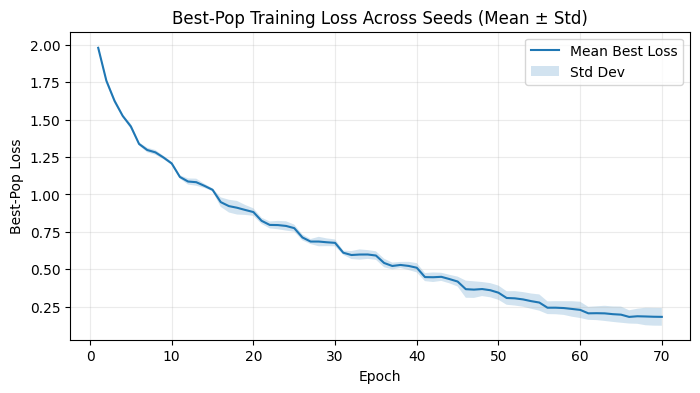

Saved: /Users/etaashpatel/Documents/Final Project/Structured Outputs/PBT/Images/fig6_pbt_bestpop_val_acc_mean_std.png
Saved: /Users/etaashpatel/Documents/Final Project/Structured Outputs/PBT/Images/fig6_pbt_bestpop_val_acc_mean_std.pdf


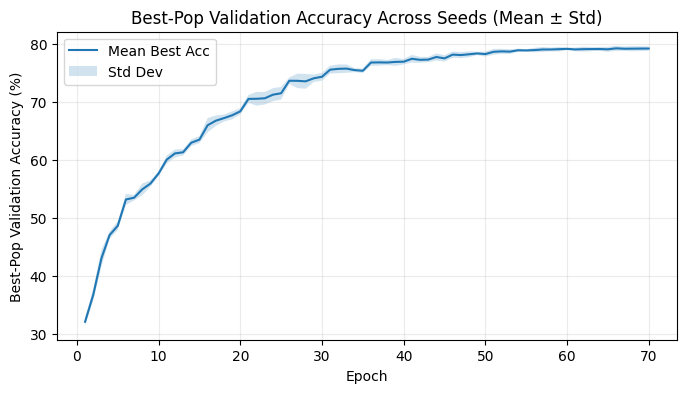

In [4]:
# === Main PBT: aggregate across seeds (Figures 5 & 6) ===
if df_main is not None:
    plot_bestpop_mean_std(
        df_main,
        title_loss='Best-Pop Training Loss Across Seeds (Mean ± Std)',
        title_acc='Best-Pop Validation Accuracy Across Seeds (Mean ± Std)',
        stem_loss='fig5_pbt_bestpop_loss_mean_std',
        stem_acc='fig6_pbt_bestpop_val_acc_mean_std',
    )

Saved: /Users/etaashpatel/Documents/Final Project/Structured Outputs/PBT/Images/fig4_pbt_representative_seed_217401.png
Saved: /Users/etaashpatel/Documents/Final Project/Structured Outputs/PBT/Images/fig4_pbt_representative_seed_217401.pdf


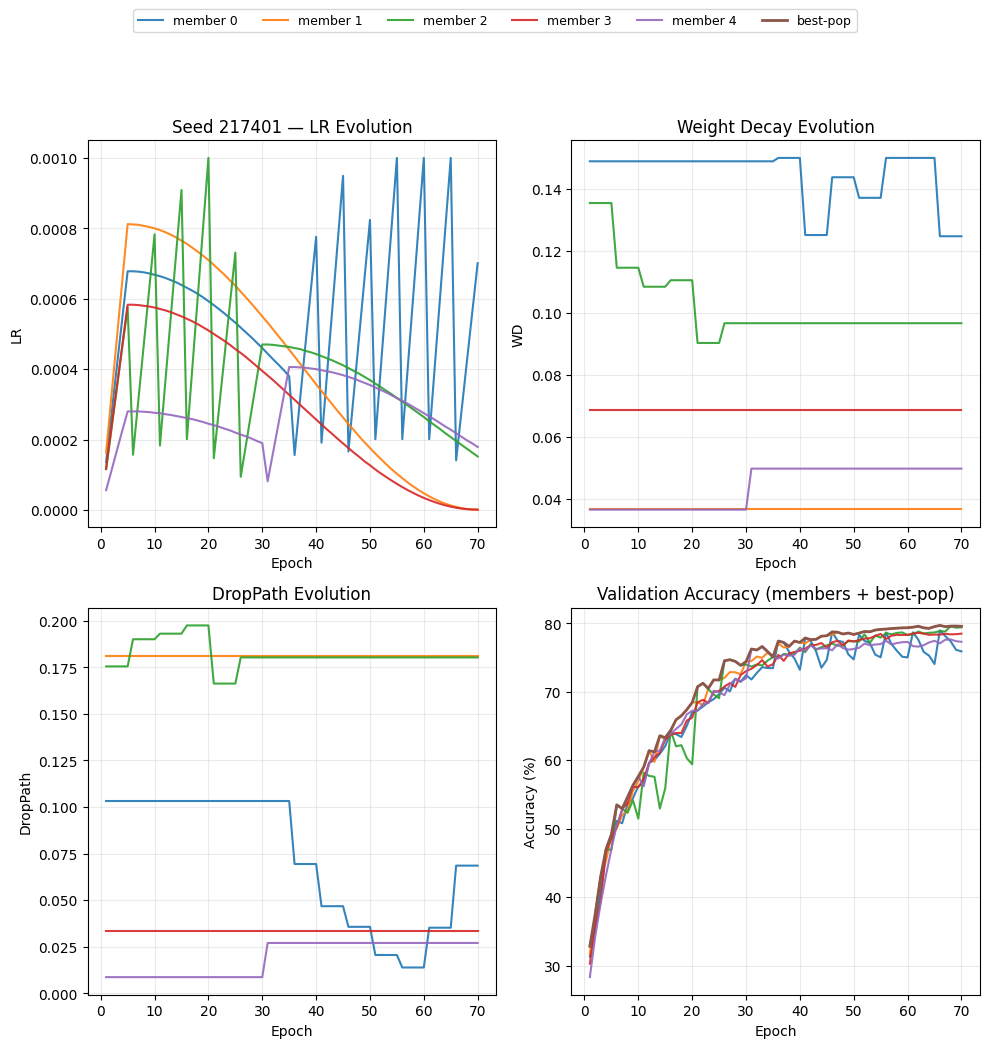

In [5]:
# === Main PBT: representative hyperparameter trajectories (Figure 4) ===
# The paper uses seed 217401 as an example (2×2 hyperparams + val acc).
if df_main is not None and 217401 in set(df_main['seed'].unique()):
    plot_seed_hparams_only(df_main, seed=217401, stem='fig4_pbt_representative_seed_217401')

Saved: /Users/etaashpatel/Documents/Final Project/Structured Outputs/PBT/Images/fig4_pbt_representative_seed_217401.png
Saved: /Users/etaashpatel/Documents/Final Project/Structured Outputs/PBT/Images/fig4_pbt_representative_seed_217401.pdf


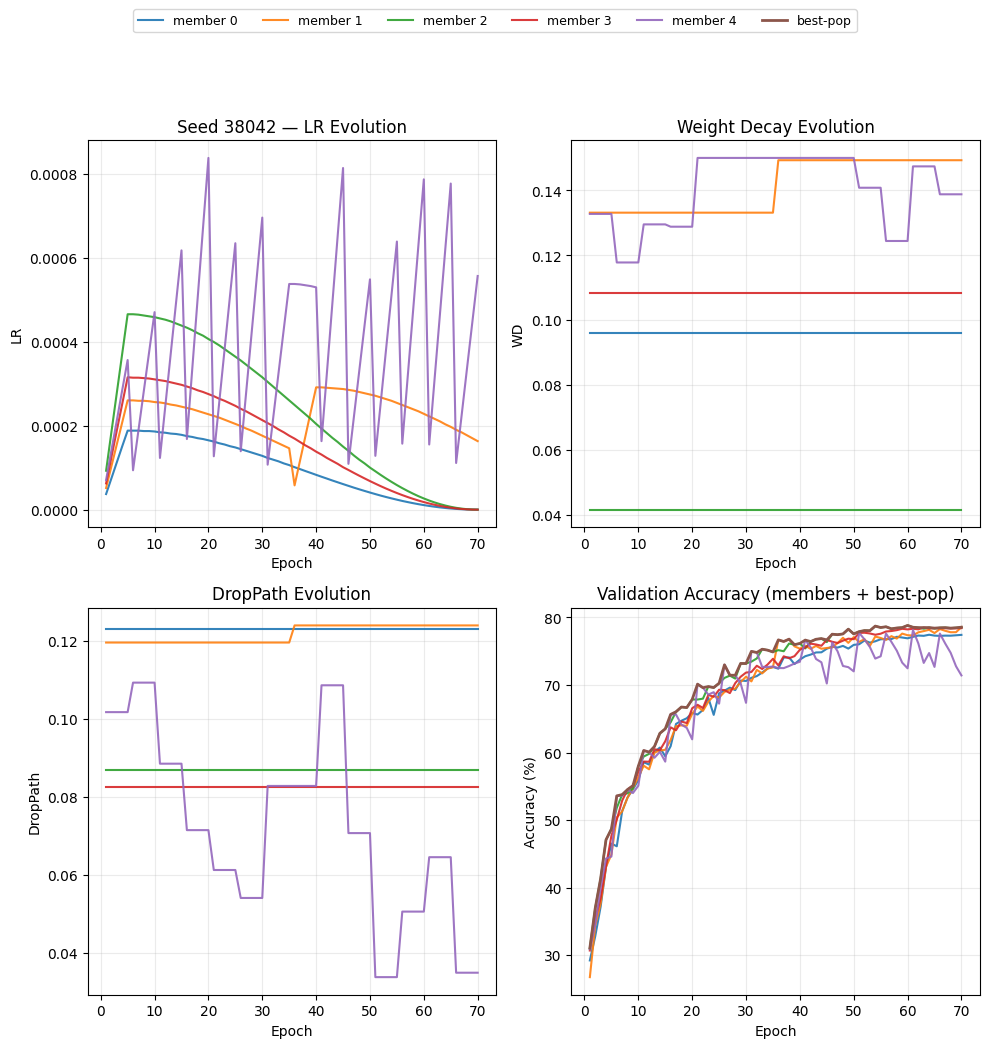

Saved: /Users/etaashpatel/Documents/Final Project/Structured Outputs/PBT/Images/fig4_pbt_representative_seed_217401.png
Saved: /Users/etaashpatel/Documents/Final Project/Structured Outputs/PBT/Images/fig4_pbt_representative_seed_217401.pdf


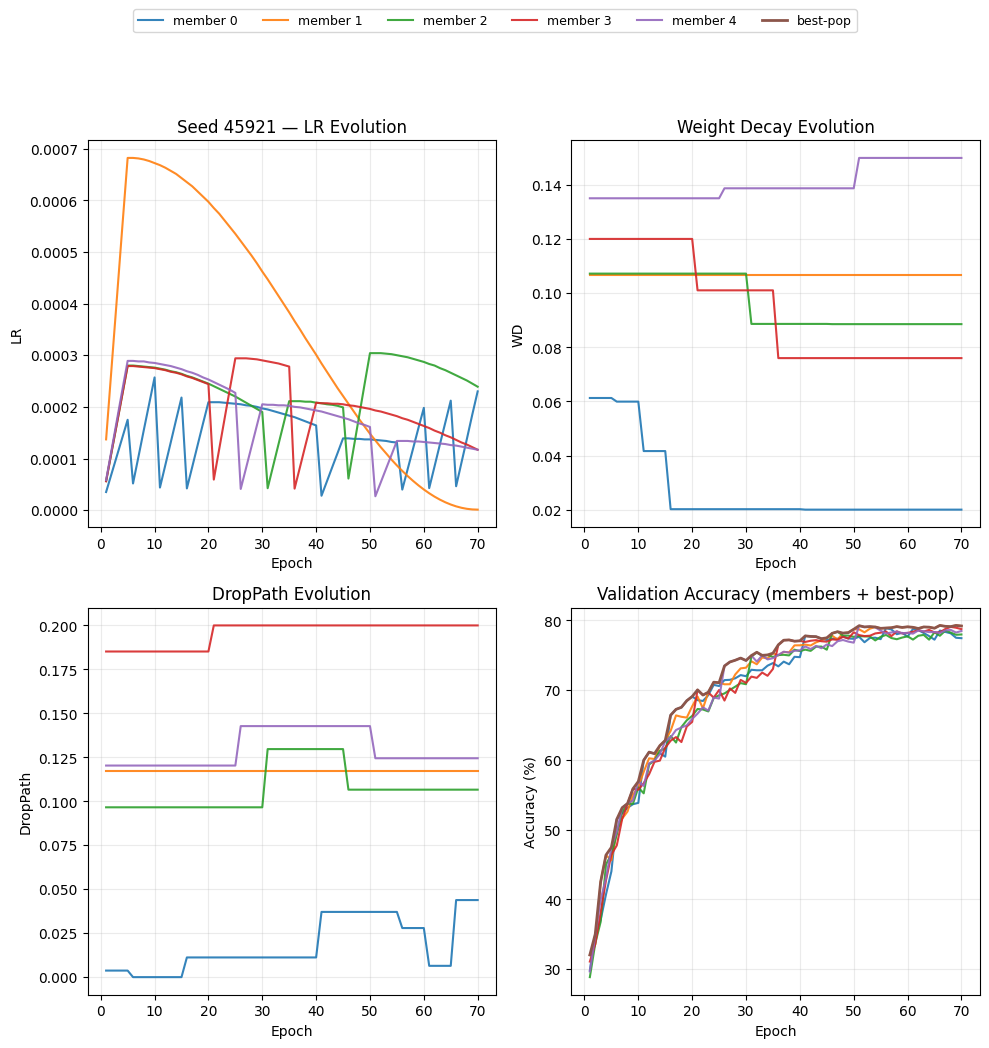

Saved: /Users/etaashpatel/Documents/Final Project/Structured Outputs/PBT/Images/fig4_pbt_representative_seed_217401.png
Saved: /Users/etaashpatel/Documents/Final Project/Structured Outputs/PBT/Images/fig4_pbt_representative_seed_217401.pdf


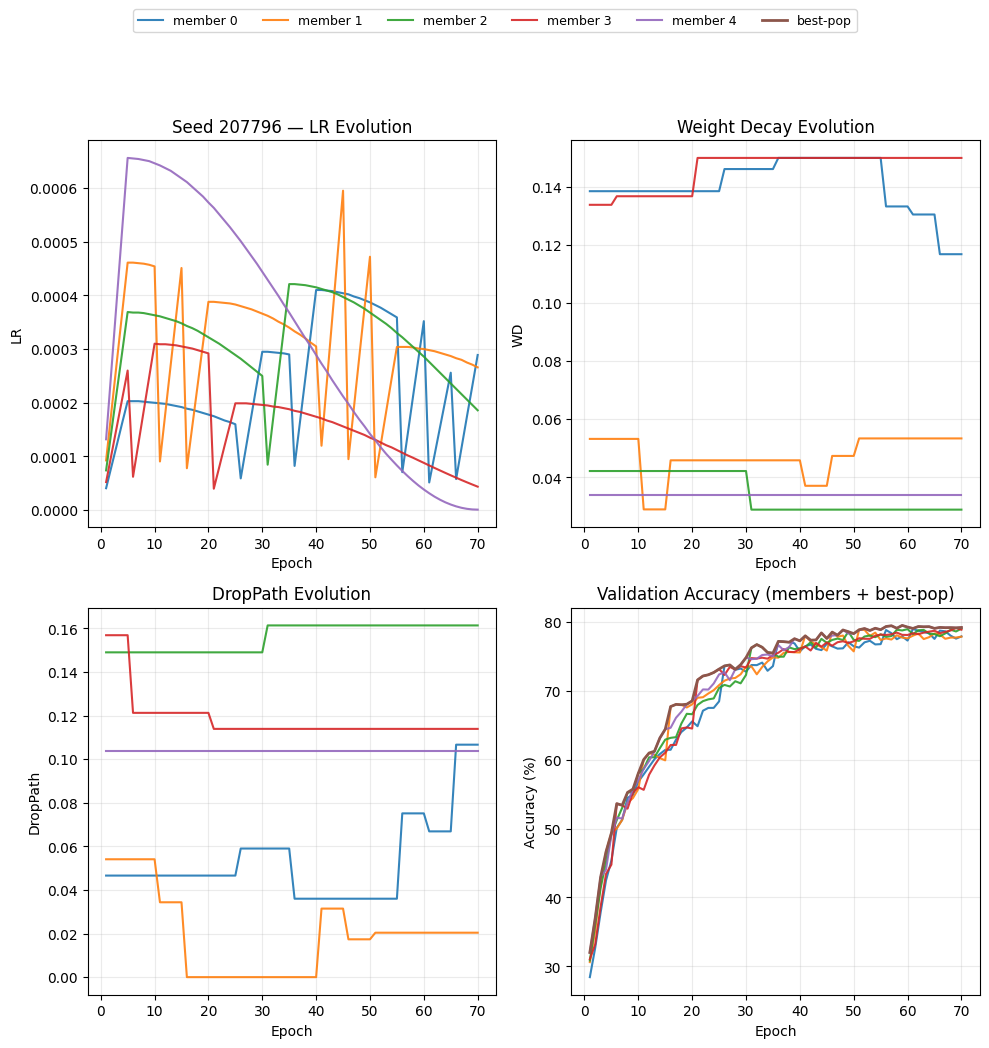

Saved: /Users/etaashpatel/Documents/Final Project/Structured Outputs/PBT/Images/fig4_pbt_representative_seed_217401.png
Saved: /Users/etaashpatel/Documents/Final Project/Structured Outputs/PBT/Images/fig4_pbt_representative_seed_217401.pdf


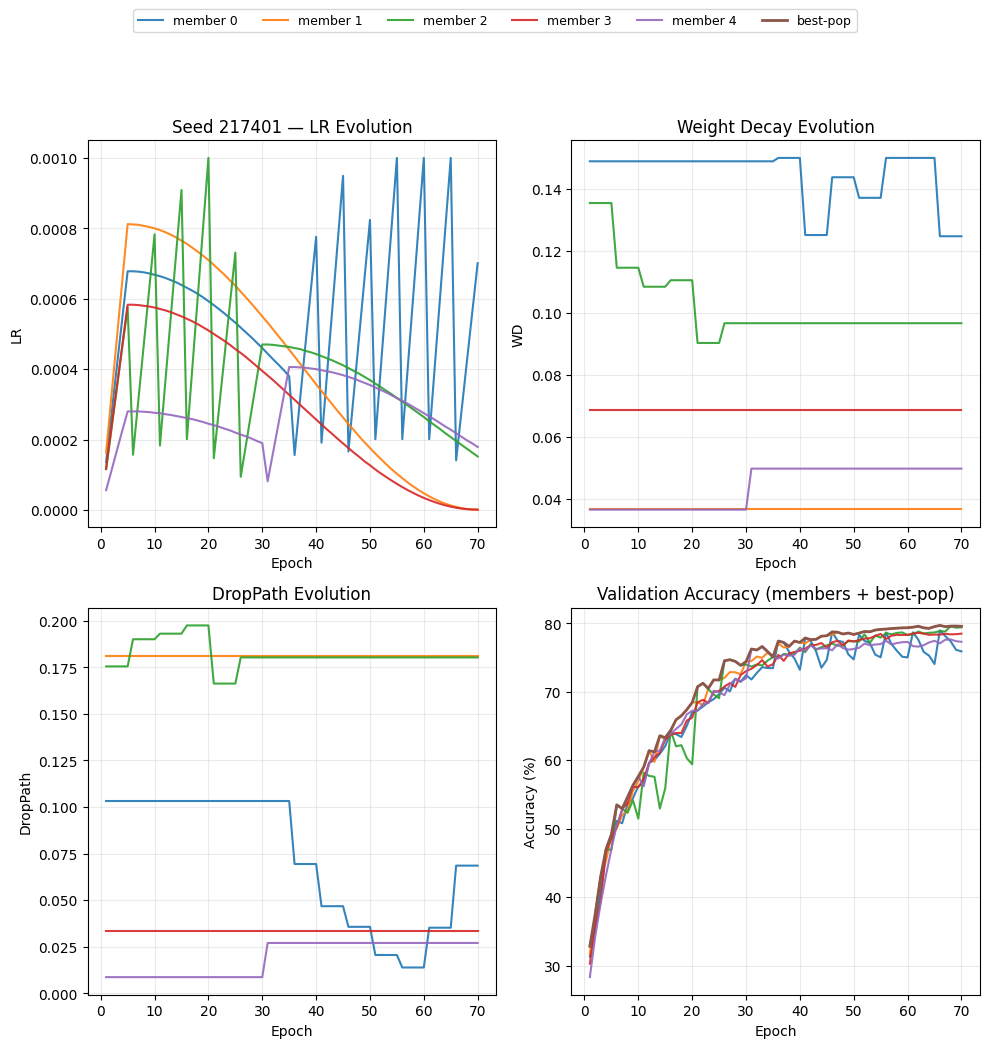

Saved: /Users/etaashpatel/Documents/Final Project/Structured Outputs/PBT/Images/fig4_pbt_representative_seed_217401.png
Saved: /Users/etaashpatel/Documents/Final Project/Structured Outputs/PBT/Images/fig4_pbt_representative_seed_217401.pdf


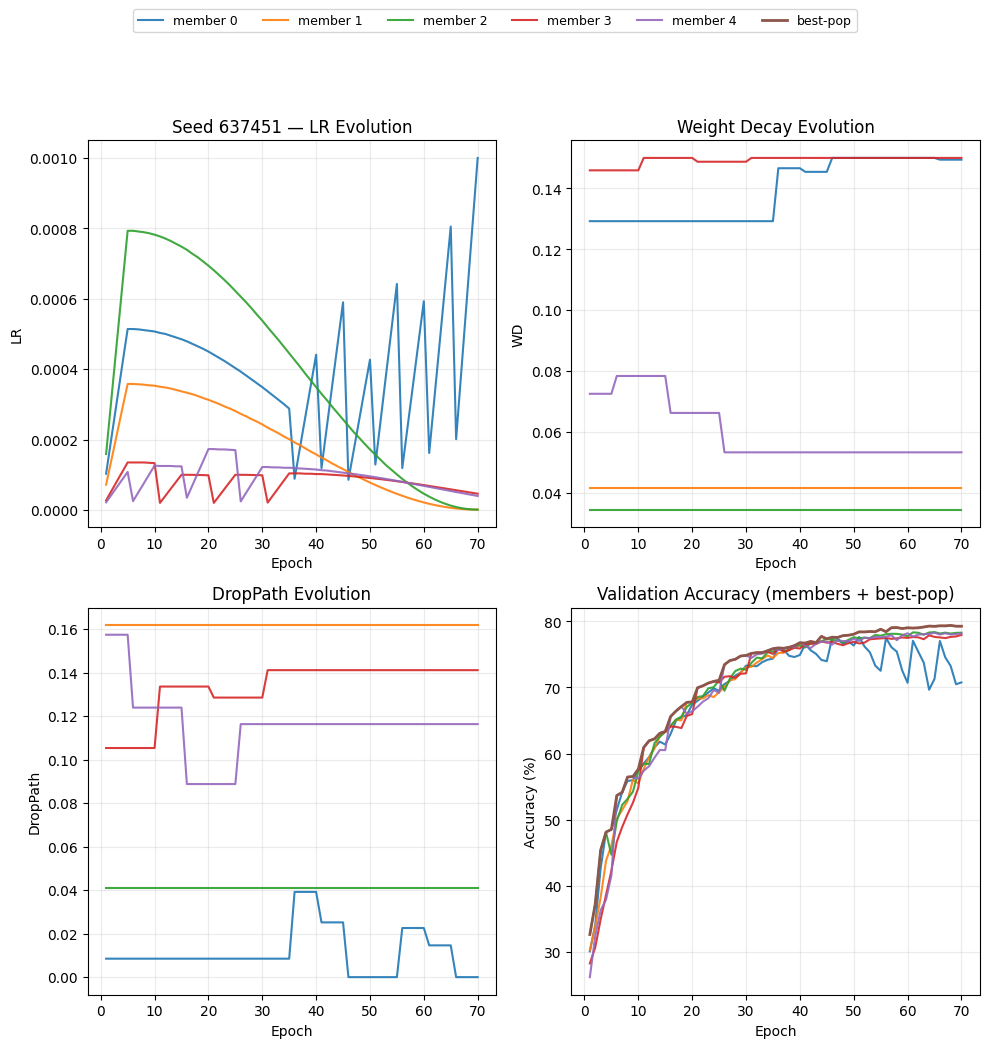

In [6]:
# === Main PBT: per-seed diagnostics (Figures 7–11 style) ===
# The paper shows a subset of seeds; we generate a figure for *every* seed present.

if df_main is not None:
    for s in sorted(df_main['seed'].unique()):
        plot_seed_hparams_only(df_main, seed=s, stem='fig4_pbt_representative_seed_217401')

In [7]:
# === Table 4: final best validation accuracy per seed under PBT ===
# We take best-of-pop validation accuracy at the final epoch.

if df_main is not None:
    best = best_of_population(df_main)
    last_epoch = int(best['epoch'].max())
    table4 = (
        best[best['epoch'] == last_epoch]
        .sort_values('best_val_acc', ascending=False)
        .rename(columns={'best_val_acc': 'Final best val. accuracy (%)'})
        [['seed', 'Final best val. accuracy (%)']]
        .reset_index(drop=True)
    )

    table4_out = OUT_DIR / 'table4_pbt_final_best_val_acc_per_seed.csv'
    table4.to_csv(table4_out, index=False)
    print(f"Saved: {table4_out}")
    table4

Saved: /Users/etaashpatel/Documents/Final Project/Structured Outputs/PBT/Images/table4_pbt_final_best_val_acc_per_seed.csv


In [8]:
# === Table 5 (optional): replacement / copy events per seed ===
# If you have the companion XLSX, we export the 'copy_events' sheet to CSV for convenience.

xlsx_main = DATA_DIR / 'pbt_experiment_pdfs_parsed.xlsx'
if xlsx_main.exists():
    try:
        copy_events = pd.read_excel(xlsx_main, sheet_name='copy_events')
        out = OUT_DIR / 'table5_pbt_copy_events.csv'
        copy_events.to_csv(out, index=False)
        print(f"Saved: {out}")
        copy_events.head(20)
    except Exception as e:
        print("Could not read 'copy_events' sheet:", e)

Saved: /Users/etaashpatel/Documents/Final Project/Structured Outputs/PBT/Images/table5_pbt_copy_events.csv


Saved: /Users/etaashpatel/Documents/Final Project/Structured Outputs/PBT/Images/fig12_13_pbt_batchsize_seed_38042.png
Saved: /Users/etaashpatel/Documents/Final Project/Structured Outputs/PBT/Images/fig12_13_pbt_batchsize_seed_38042.pdf


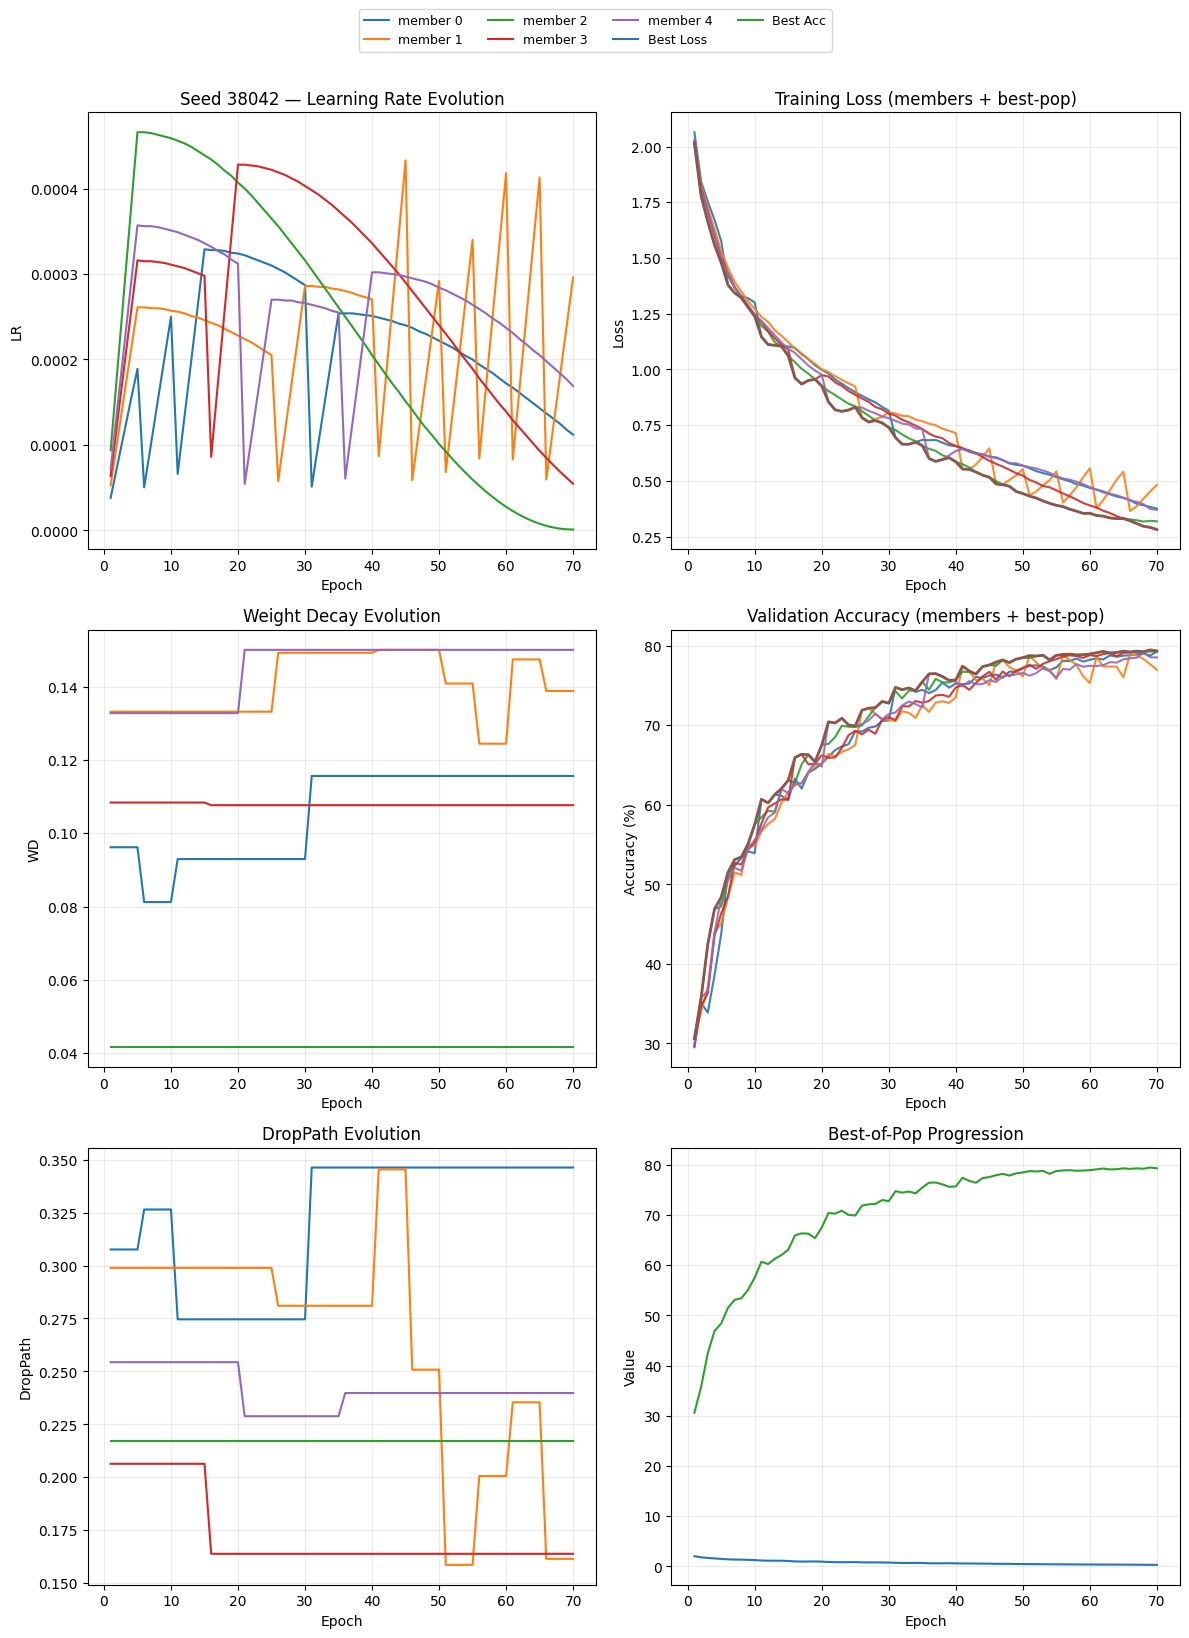

Saved: /Users/etaashpatel/Documents/Final Project/Structured Outputs/PBT/Images/fig12_13_pbt_batchsize_seed_217401.png
Saved: /Users/etaashpatel/Documents/Final Project/Structured Outputs/PBT/Images/fig12_13_pbt_batchsize_seed_217401.pdf


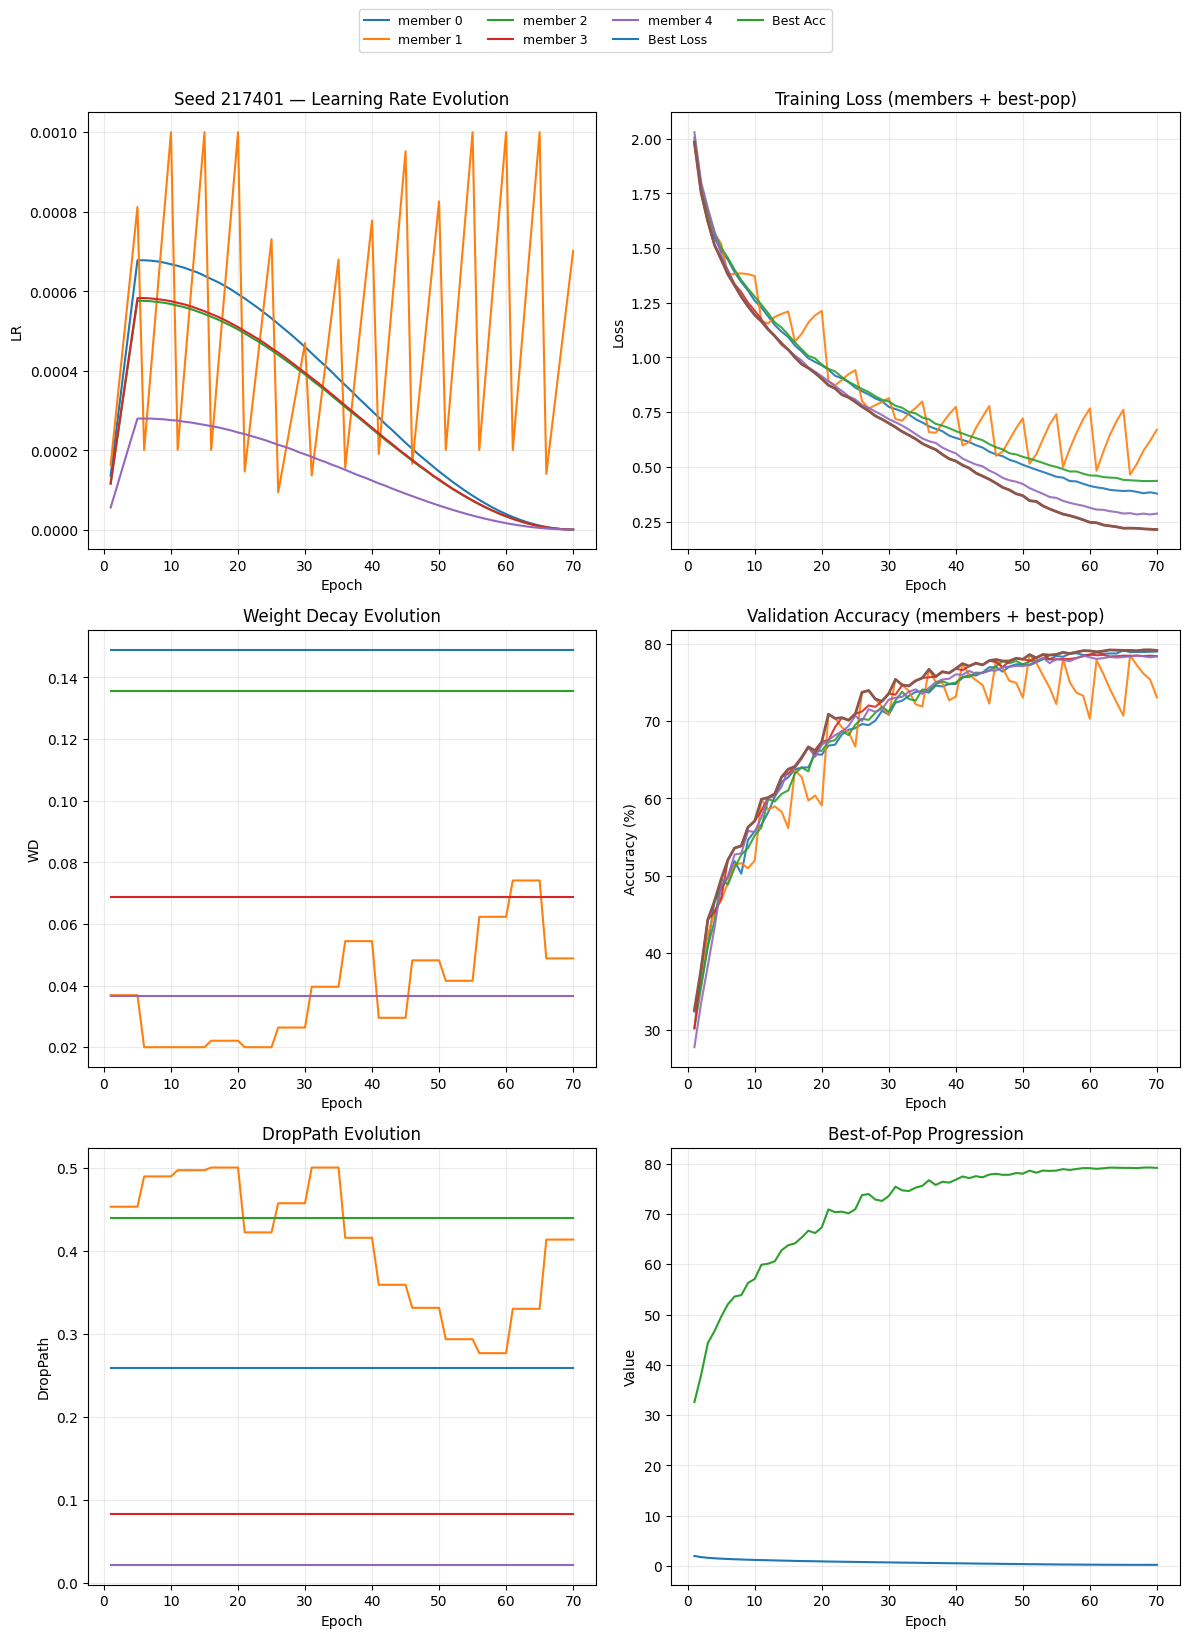

In [9]:
# === Ablation 1: batch-size mutations (Figures 12–13 style) ===
# The paper's batch-size ablation figures keep the same 3×2 layout (no extra batch-size panel).
if df_bs is not None:
    for s in sorted(df_bs['seed'].unique()):
        plot_seed_dynamics(df_bs, seed=int(s), stem=f'fig12_13_pbt_batchsize_seed_{int(s)}', title_prefix='Seed', include_batch_size_panel=False)

Saved: /Users/etaashpatel/Documents/Final Project/Structured Outputs/PBT/Images/fig14_pbt_wd_ablation_seed_38042.png
Saved: /Users/etaashpatel/Documents/Final Project/Structured Outputs/PBT/Images/fig14_pbt_wd_ablation_seed_38042.pdf


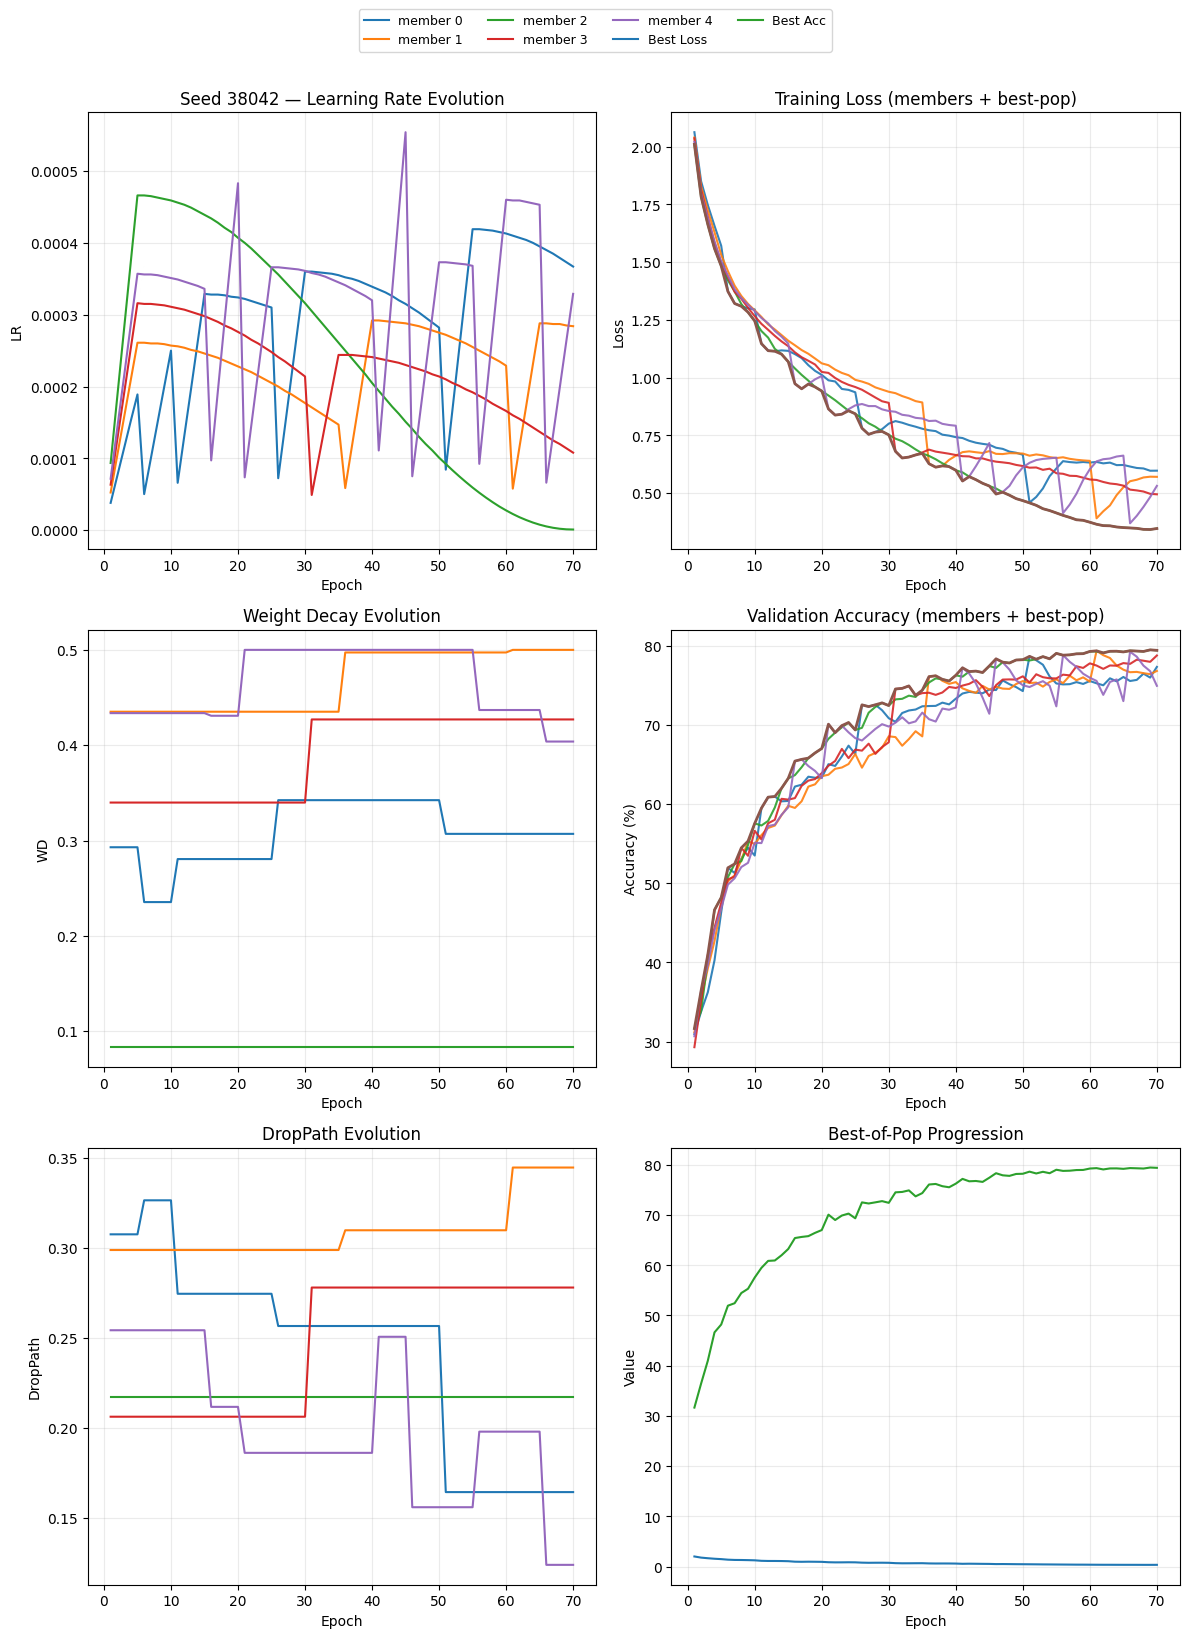

In [10]:
# === Ablation 2: larger weight-decay bounds only (Figure 14 style) ===
if df_wd is not None:
    for s in sorted(df_wd['seed'].unique()):
        plot_seed_dynamics(df_wd, seed=int(s), stem=f'fig14_pbt_wd_ablation_seed_{int(s)}', title_prefix='Seed', include_batch_size_panel=False)

Saved: /Users/etaashpatel/Documents/Final Project/Structured Outputs/PBT/Images/fig15_pbt_wd_bs_bestpop_loss_mean_std.png
Saved: /Users/etaashpatel/Documents/Final Project/Structured Outputs/PBT/Images/fig15_pbt_wd_bs_bestpop_loss_mean_std.pdf


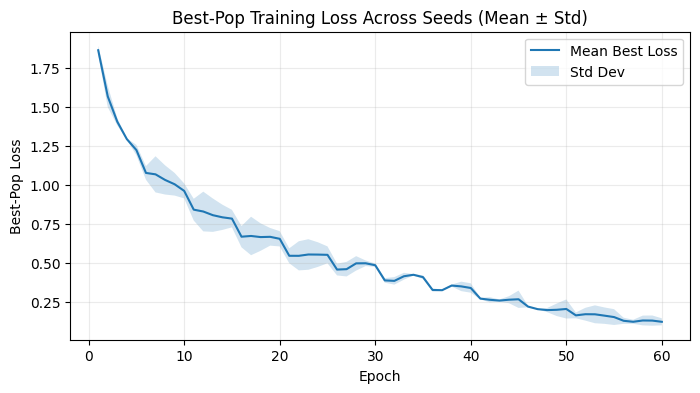

Saved: /Users/etaashpatel/Documents/Final Project/Structured Outputs/PBT/Images/fig16_pbt_wd_bs_bestpop_val_acc_mean_std.png
Saved: /Users/etaashpatel/Documents/Final Project/Structured Outputs/PBT/Images/fig16_pbt_wd_bs_bestpop_val_acc_mean_std.pdf


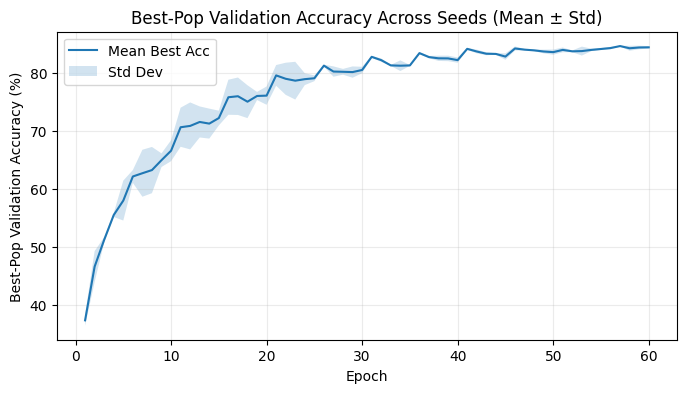

In [11]:
# === Ablation 3: larger weight-decay bounds + batch-size tuning (Figures 15–18) ===
if df_bsw is not None:
    # Aggregate across seeds (Figures 15 & 16)
    plot_bestpop_mean_std(
        df_bsw,
        title_loss='Best-Pop Training Loss Across Seeds (Mean ± Std)',
        title_acc='Best-Pop Validation Accuracy Across Seeds (Mean ± Std)',
        stem_loss='fig15_pbt_wd_bs_bestpop_loss_mean_std',
        stem_acc='fig16_pbt_wd_bs_bestpop_val_acc_mean_std',
    )

Saved: /Users/etaashpatel/Documents/Final Project/Structured Outputs/PBT/Images/fig17_18_pbt_wd_bs_seed_38042.png
Saved: /Users/etaashpatel/Documents/Final Project/Structured Outputs/PBT/Images/fig17_18_pbt_wd_bs_seed_38042.pdf


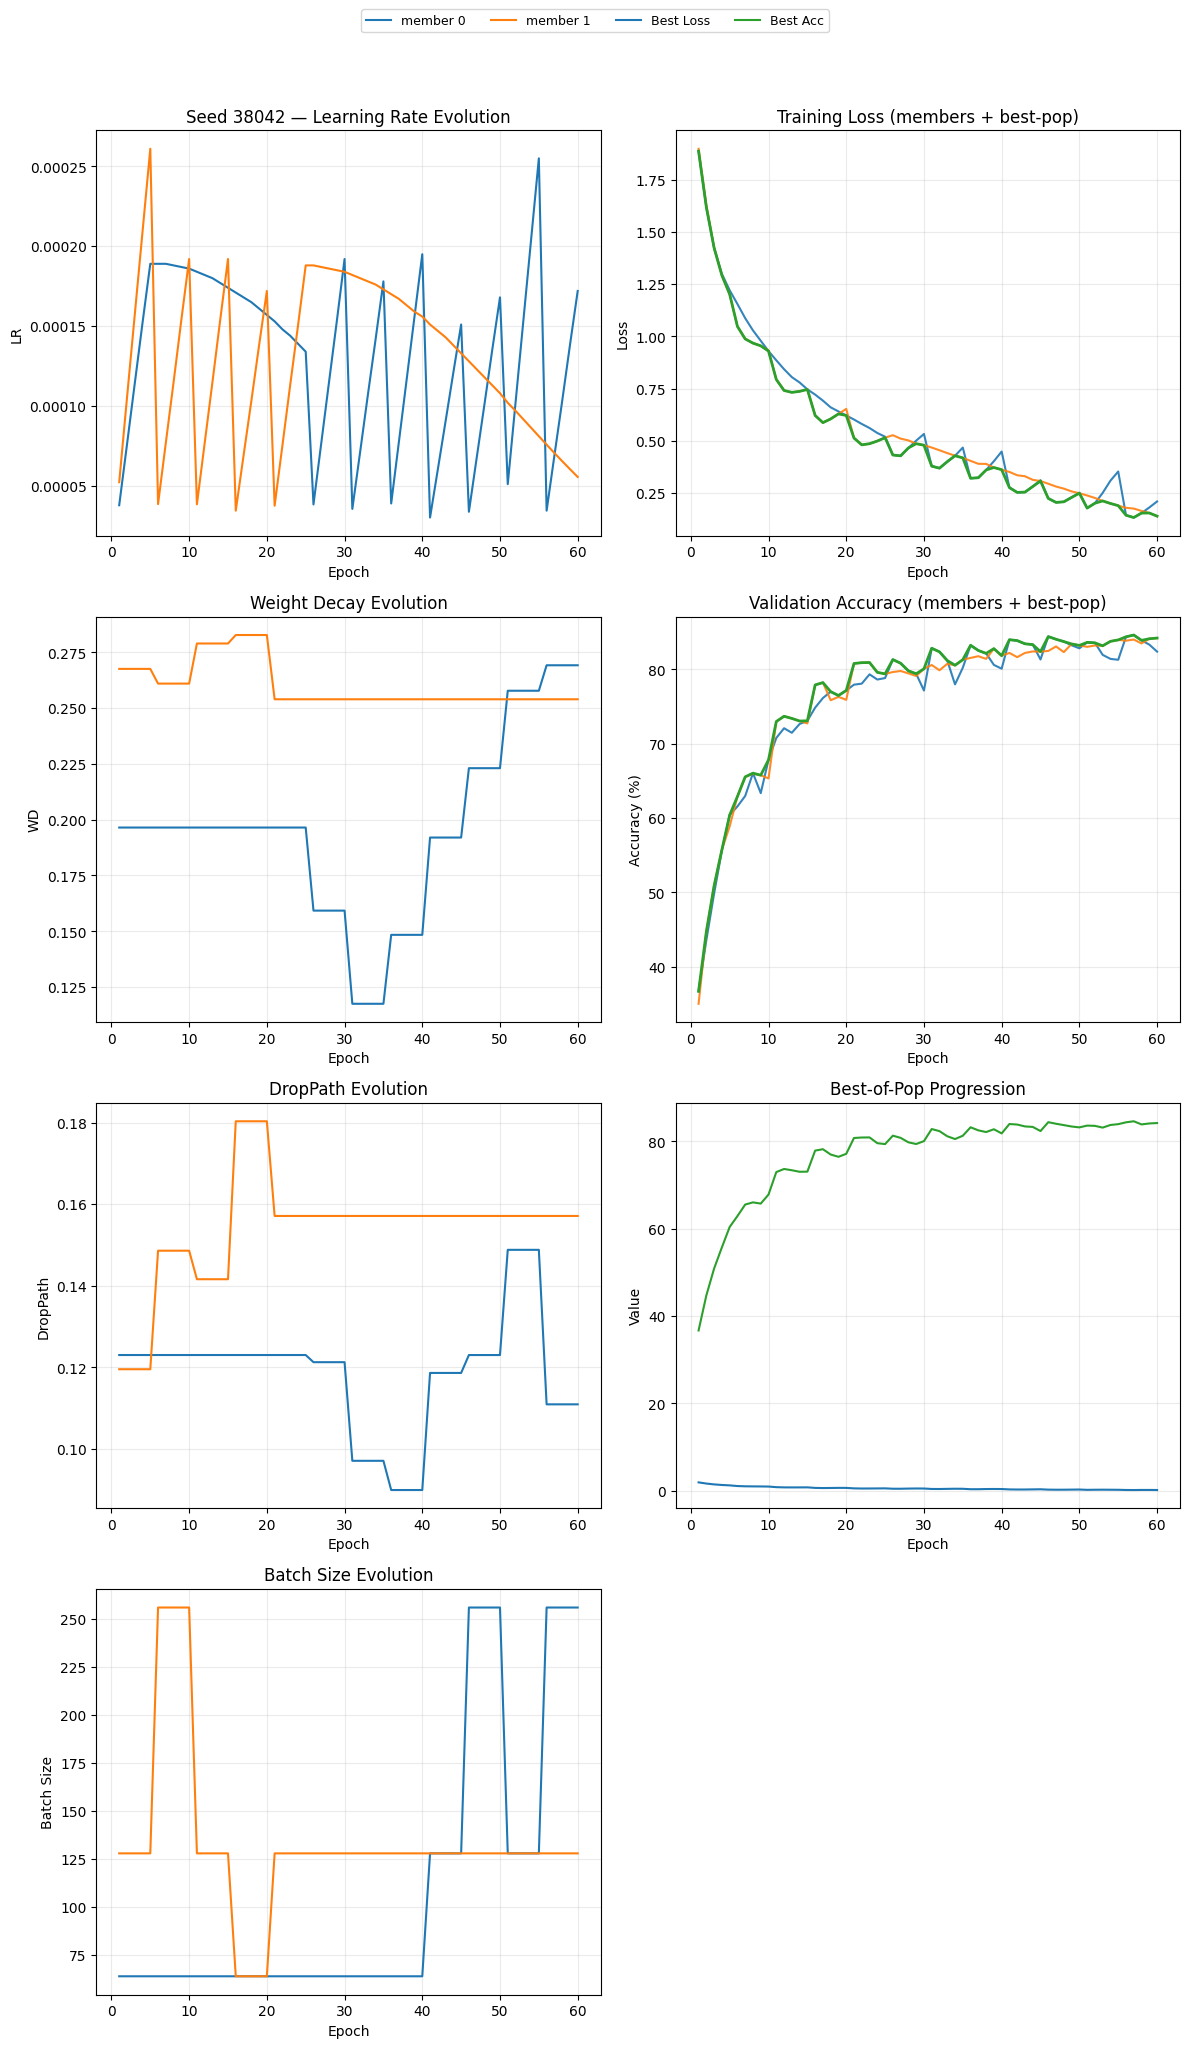

Saved: /Users/etaashpatel/Documents/Final Project/Structured Outputs/PBT/Images/fig17_18_pbt_wd_bs_seed_217401.png
Saved: /Users/etaashpatel/Documents/Final Project/Structured Outputs/PBT/Images/fig17_18_pbt_wd_bs_seed_217401.pdf


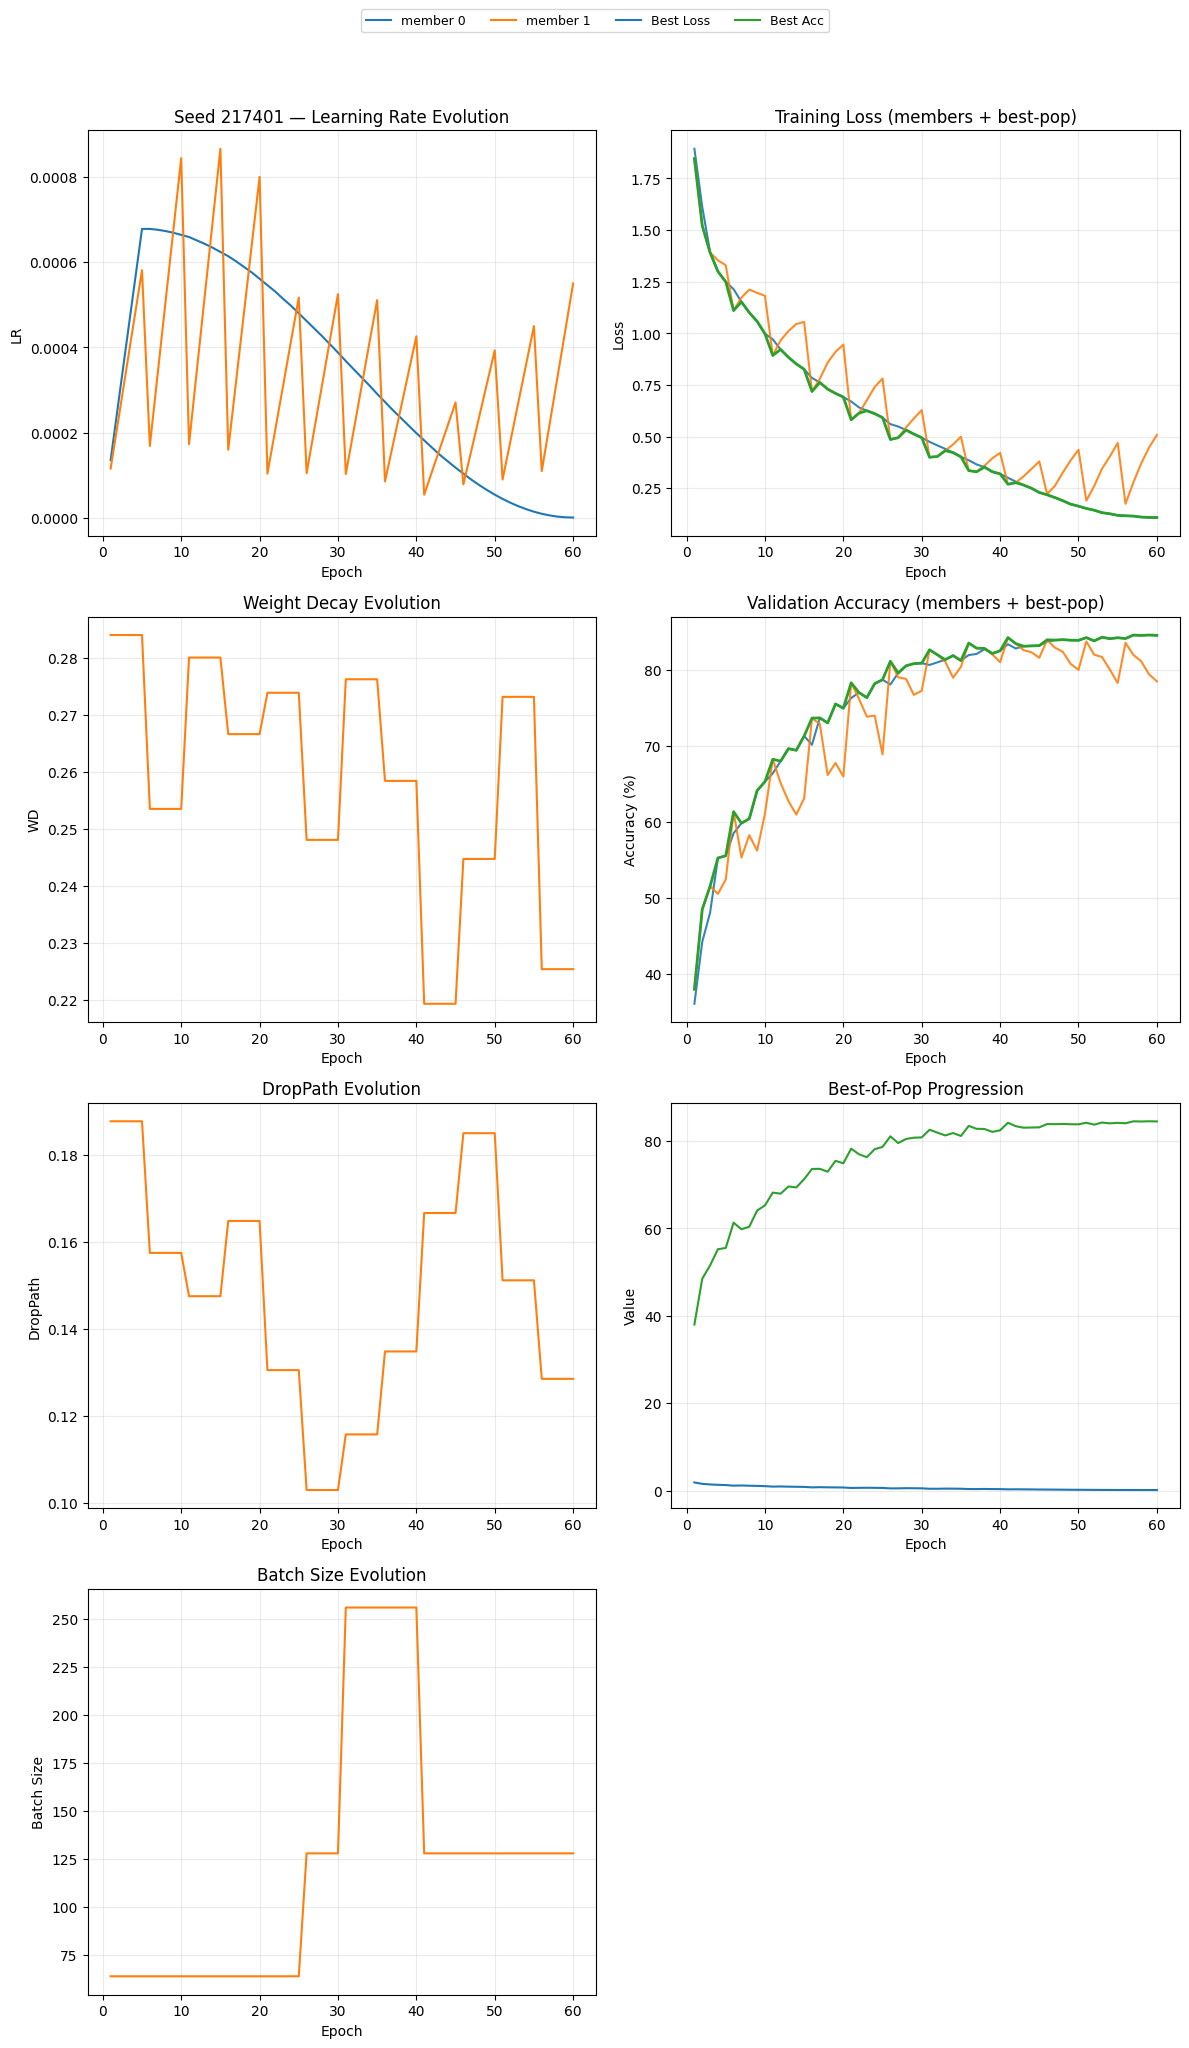

In [12]:
    # Per-seed diagnostics (Figures 17–18 style)
for s in sorted(df_bsw['seed'].unique()):
    plot_seed_dynamics(df_bsw, seed=int(s), stem=f'fig17_18_pbt_wd_bs_seed_{int(s)}', title_prefix='Seed', include_batch_size_panel=True)